# KI-Werkbank
# MNIST 99,64% - Mit einem einfachen Convolutional Neuronal Network (CNN) unter die Top 10%

## Worum geht es hier?
In meinen letzten Blogs habe ich die einzelnen Bausteine eines Convolutional Neuronal Networks beschrieben, das designtechnisch im Jahre 2018 angekommen ist. 

Auf der Plattform [Kaggle.com](https://www.kaggle.com) fand in den letzten Jahren ein Wettstreit statt, handgeschriebene Ziffern per Machine Learning zu erkennen. Der Rekord bei der Trefferrate liegt im Augenblick jenseits der 99,7% aber knapp unter 99,8%. Der Bereich oberhalb der 99,8% wird als unmöglich zu erreichen betrachtet. Lässt man sich die Kandidaten in diesem Grenzbereich einmal anzeigen, versteht man auch warum. Es sind so unordentlich geschriebene Ziffern, dass weder Mensch noch Maschine diese eindeutig bestimmen können.

Die Architektur, die ich hier nun aus allen Einzelteilen zusammenbaue, kommt zu einer Genauigkeit von 99,64% und ist somit unter den Top Kandidaten. Damit möchte ich zeigen, dass neuronale Hochleistungsnetze keine Zauberei, sondern solide Ingenieurskunst sind. Man muss also nicht in einem Geheimlabor der NSA 100 Meter unter der Erde arbeiten um das zu können, sondern kann sich mit viel Liebe zum Detail dem Ziel zügig nähern.

Da ich die Einzelteile ja bereits sehr ausführlich beschrieben habe, werde ich bis auf eine Ausnahme (CallBacks) nicht mehr viel beschreiben. Falls Dir also die dargereichten Erklärungen zu schmal scheinen, möchte ich dich bitten, in den vorherigen Blogs nachzulesen.


## Die Bauanleitung
### Boiler Plate

In [2]:
#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

#keras
import keras
from keras.backend.tensorflow_backend import set_session
from keras.datasets import mnist
from keras import models
from keras import layers
from keras import regularizers
from keras.utils import to_categorical
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras import callbacks

#numpy
import numpy as np

#sklearn
from sklearn.metrics import confusion_matrix

#itertools
import itertools

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#time
import time

#os
import os

#Force GPU support with growing memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


### Trainings und Testdaten besorgen

In [3]:
#keras / tensorflow has already the full MNIST dataset
(train_images_raw, train_labels_raw), (test_images_raw, test_labels_raw) = mnist.load_data()

### Samples und Features normieren und aufsplitten

In [4]:
#fraktion of the training to the validation samples
a_train = int(train_images_raw.shape[0] * 0.9)

images = train_images_raw.reshape((train_images_raw.shape[0], 28, 28, 1))
images = images.astype('float32') / 255 #255 different gray scales

train_images = images[ : a_train]
valid_images = images[a_train : ]
print("Amount of all images:{}".format(images.shape))
print("Amount of all training images:{}".format(train_images.shape))
print("Amount of all validation images:{}".format(valid_images.shape))

#convert labels into one hot representation
labels = to_categorical(train_labels_raw)
train_labels = labels[ : a_train]
valid_labels = labels[a_train : ]
print("Amount of all labels:{}".format(labels.shape))
print("Amount of all training labels:{}".format(train_labels.shape))
print("Amount of all validation labels:{}".format(valid_labels.shape))


test_images = test_images_raw.reshape((test_images_raw.shape[0], 28, 28, 1))
test_images = test_images.astype('float32') / 255 #255 different gray scales
test_labels = to_categorical(test_labels_raw)

Amount of all images:(60000, 28, 28, 1)
Amount of all training images:(54000, 28, 28, 1)
Amount of all validation images:(6000, 28, 28, 1)
Amount of all labels:(60000, 10)
Amount of all training labels:(54000, 10)
Amount of all validation labels:(6000, 10)


### Das Netz zusammen bauen

Anmerkung: hier habe ich die Konfiguration des `optimizers` herausgezogen, um die anfängliche Lernrate `lr` explizit zu setzen 

In [5]:
model = models.Sequential()
# Convolution Layers
model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (5, 5), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(layers.Dropout(0.4))

# Fully connected Layers
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10 , activation='softmax'))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
__________

### Zum Augmentieren der Daten: Der `ImageDataGenerator`

In [6]:
datagen = ImageDataGenerator(
    # Wieviel Grad [0, 180] darf sich das Bild hin und her drehen
    rotation_range = 10, 
    # Um wieviel darf das Bild nach links und rechts bewegt werden
    width_shift_range=0.1, 
    # Um wieviel darf das Bild nach Oben und Unten bewegt werden
    height_shift_range=0.1, 
    # Die Varianz von dunkel zu hell 
    #brightness_range = (0.1, 2), 
    # In welchem Bereich darf das Bild abgeschert werden
    shear_range = 0.1, 
    # In welchem Bereich dar das Bild die größe ändern
    zoom_range = 0.1, 
    # Bei Zahlen sollte man auf das Spiegeln eher verzichten :)
    horizontal_flip = False, 
    # Bei Zahlen sollte man auf das Spiegeln eher verzichten :)
    vertical_flip = False)

### Callbacks zum Überwachen
Das ist eine Technik, die ich vorher noch nicht beschrieben habe. Mit Callbacks kann man das Training des Modells überwachen und bei Bedarf eingreifen. Die nun folgenden drei Callbacks tun genau dies

#### Überwachen der Lernrate
Die Lernrate ist die Schrittweite, mit der das Gradienten Verfahren bei der Suche nach dem Minima im Hypothesenraum den nächsten Schritt macht. 

Das Bild, das man dazu oft findet, ist der Bergsteiger, der den Weg hinunter ins Tal sucht. Wenn der Bergsteiger im Vergleich zu den Bergen zu klein ist, wird er mit seinen Trippelschrittchen einfach in die nächstbeste Delle laufen und diese für das absolute Minimum halten. 

Ist der Bergsteiger aber riesengroß, dann besteht die Gefahr, dass er über das entscheidende Tal einfach drübersteigt. 

Ein Indikator für das aktuelle Gelände, durch das der Bergsteiger gerade läuft, ist die Verlustrate der letzten Validierungsschritte. Ändert diese sich kaum noch, so ist der Bergsteiger anscheinend in einem Tal angekommen. Hier zeigt die Erfahrung, dass es sinnvoll ist, die Lernrate zu verkleinern und genau das macht der `ReduceLROnPlateau` Callback im laufenden Betrieb.

In [7]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(
                                            # val_acc zeigt die letzten verlusraten
                                            monitor='val_acc', 
                                            # wie lange halten wir die Fuesse still, bevor wir die Lernrate anpassen
                                            patience=3, 
                                            verbose=1,
                                            # Die lernrate wird halbiert
                                            factor=0.5, 
                                            # ab wann brechen wir ab
                                            min_lr=0.00001)

#### Aufhören, wenn es nichts mehr bringt
Wenn sich die Genauigkeit nicht mehr ändert, können wir mit dem Training auch aufhören. Damit entledigt man sich des Problems die Anzahl der Lernraten sinnvoll zu belegen.

In [8]:
early_stopping = callbacks.EarlyStopping(
                                            # über welchen Monitor beobachtet man die Änderung der letzten Iterationen?
                                            monitor = 'acc',
                                            # wie lange halten wir die Fuesse still, bis wir das Lernen abbrechen
                                            patience = 3)

#### Nichts wegschmeißen
Wenn man sich in das perfekte Modell hineindreht, überläuft man eigentlich immer den optimalen Punkt, an dem das Modell die beste Genauigkeit hatte. Leider ist dieser Punkt mit der nächsten Epoche unwiederbringlich verloren, da die Gewichte bereits geändert wurden. Um diesem Dilemma vorzubeugen, speichere ich das jeweils beste Modell ab. Hat sich die Qualität also im Vergleich zu den vorherigen Berechnungen verbessert, schreibe ich das Modell auf die Festplatte. Somit habe ich immer das beste Modell eines Laufs gerettet.

In [9]:
model_checkpoint = callbacks.ModelCheckpoint(
                                            # Dateiname mit Pfad relativ zu dieserm Code
                                            filepath = 'persist_model/augmenting_cnn_MNIST_model.h5',
                                            # Welcher Monitor soll beobachtet werden, um über die äbderung der Qualität zu entscheiden
                                            monitor = 'val_loss',
                                            # Nur speciern, wenn sich auch was verbessert hat
                                            save_best_only = True)

### Los geht’s
Wenn du deine GPU Unterstützung nicht aktiviert hast, solltest du hier aufhören, oder es wird ein sehr langes Wochenende, bis dein Rechner aus der Versenkung wieder auftaucht. Das Normalisieren der Ergebnisse dauert lange. 

In [37]:
start = time.time()
epochs = 200
batch_size = 256
history  = model.fit_generator(
    datagen.flow(train_images, train_labels, batch_size = batch_size), 
    steps_per_epoch = train_images.shape[0] // batch_size, 
    epochs = epochs,
    validation_data = (valid_images, valid_labels),
    callbacks=[learning_rate_reduction, early_stopping, model_checkpoint]
)

print("It took:", time.time() - start)


Epoch 1/200
210/210 [==============================] - 36s 173ms/step - loss: 0.9621 - acc: 0.7322 - val_loss: 0.1943 - val_acc: 0.9547
Epoch 2/200
210/210 [==============================] - 32s 153ms/step - loss: 0.2421 - acc: 0.9325 - val_loss: 0.0697 - val_acc: 0.9847
Epoch 3/200
210/210 [==============================] - 32s 155ms/step - loss: 0.1665 - acc: 0.9560 - val_loss: 0.0503 - val_acc: 0.9880
Epoch 4/200
210/210 [==============================] - 35s 167ms/step - loss: 0.1309 - acc: 0.9662 - val_loss: 0.0506 - val_acc: 0.9885s: 0.1319 - acc
Epoch 5/200
210/210 [==============================] - 52s 249ms/step - loss: 0.1078 - acc: 0.9714 - val_loss: 0.0393 - val_acc: 0.9912
Epoch 6/200
210/210 [==============================] - 93s 442ms/step - loss: 0.0984 - acc: 0.9746 - val_loss: 0.0304 - val_acc: 0.9928
Epoch 7/200
210/210 [==============================] - 93s 442ms/step - loss: 0.0914 - acc: 0.9766 - val_loss: 0.0345 - val_acc: 0.9902

Epoch 00007: ReduceLROnPlateau r

### Speichern
Ich speichere hier das Modell noch einmal explizit ab, da in meinem Fall das letzte Ergebnis das Beste ist, obwohl sich die Verlustrate nicht gebessert hat.

In [54]:
# serialize model to JSON
model.save('persist_model/final_augmenting_cnn_MNIST_model.h5')

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("persist_model/final_augmenting_cnn_MNIST_model.json", "w") as json_file:
    json_file.write(model_json)

### Trainingsverlauf interpretieren
Man sieht, dass die Kurve hier einen absoluten Lehrbuchcharakter hat. Beide Verläufe schmiegen sich mehr und mehr aneinander an und streben gemeinsam asymptotisch die Horizontale an. Ein mathematisches Happy End :)

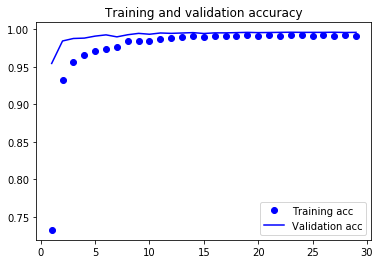

Abb 1: Anstieg der Genauigkeit über die Epochen



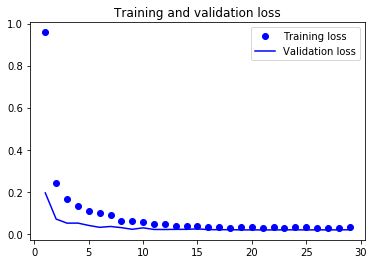

Abb 2: Abnahme des Fehlers über die Epochen



In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("Abb 1: Anstieg der Genauigkeit über die Epochen")
print("")

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
print("Abb 2: Abnahme des Fehlers über die Epochen")
print("")

### Model Testen
Für den Test verwende ich wirklich das abgespeicherte Modell um alle Seiteneffekte auszuschließen und um mir sicher zu sein, dass ich das Ergebnis später auch nutzen kann.

In [7]:
main_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
mod_dir = os.path.join(main_dir,'train_model', 'persist_model')

test_model = models.load_model(os.path.join(mod_dir, 'final_augmenting_cnn_MNIST_model.h5'))

(test_loss, test_acc) = test_model.evaluate(test_images, test_labels)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

10000/10000 [==============================] - 5s 526us/step
Loss:  0.012790212325054472
Accuracy:  0.9964


### Fehleranalyse
Es gibt eine sehr schöne Grafik, um die Ausreißer lokalisieren zu können: Die __Confusion Matrix__. Nach rechts sind dabei die Ziffern angetragen, die das Modell erkannt hat und nach oben die Ziffern, die das Modell hätte erkennen sollen. Somit ist es Ziel der Übung möglichst alle Werte auf die Diagonale zu treiben und den Rest zu Null zu trimmen.

Die Ausreißer habe ich in der Grafik rot markiert. Dadurch springt ins Auge, dass wie zu erwarten die Vier und die Neun den meisten Ärger machen. 


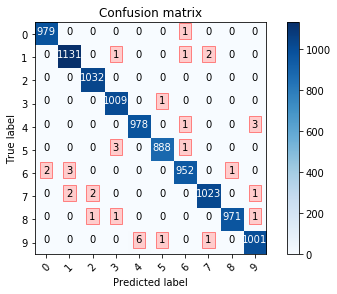

Abb 3: Confusion Matrix


In [36]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(confusion_matrix, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black",
                 bbox = None if confusion_matrix[i , j] == 0 or i == j else dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
                 )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
labels_pred = test_model.predict(test_images)
# Convert predictions classes to one hot vectors 
labels_pred = np.argmax(labels_pred, axis = 1) 
# Convert validation observations to one hot vectors
labels_true = np.argmax(test_labels, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(labels_true, labels_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, labels = range(10))
plt.show()
print('Abb 3: Confusion Matrix')

Hier sind alle falsch erkannten Vier - Neun Kombinationen zu sehen

36 von 10000 wurden falsch erkannt.


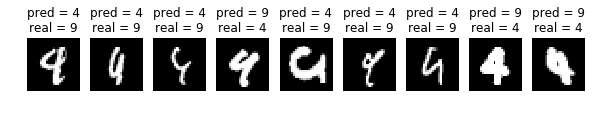

Abb 4: Schwierigkeiten zwischen 4 und 9


In [63]:
examples = []
wrong = 0

for index, pred in enumerate(labels_pred):
    real = labels_true[index]
    
    if pred != real:
        wrong += 1
    
    if pred in (4,9):
        if real in (4,9) and real != pred:
            examples.append((real, pred, test_images[index]))

print('{} von {} wurden falsch erkannt.'.format(wrong, len(labels_pred)))
fig = plt.figure(figsize=(10, 10))

for index, (real, pred, image) in enumerate(examples):
        ax = fig.add_subplot(1, len(examples), index + 1)
        ax.axis('off')
        ax.title.set_text('pred = {}\nreal = {}'.format(pred,real))
        ax.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()
print('Abb 4: Schwierigkeiten zwischen 4 und 9')

## Schluss

Es gibt nun noch zwei Werkzeuge / Techniken, mit denen man das Ergebnis noch verbessern könnte. Das eine ist ein Tool zum automatischen und systematischen justieren der Metaparameter, damit man eine möglichst optimale Konfiguration der Metaparameter erhält. Zum Anderen kann man ein ganzes Ensemble von Modellen trainieren und deren Ergebnisse gemeinsam nutzen. Beides braucht naturgemäß während des Trainings extrem viel Rechenzeit, dennoch kann ein wirklich ausgereiftes und produktiv genutztes Modell nicht darauf verzichten. Bei unserem Modell würden wir sicherlich die letzten beiden Vieren aus der obigen Abbildung noch richtig erkannt bekommen und könnten somit in einen produktiven Betrieb gehen. 

Nichts desto trotz ist das Ergebnis schon sehr zufriedenstellend, wenn man bedenkt, dass von 10.000 Ziffern nur 36 falsch erkannt wurden und dass unter diesen 36 auch noch Ziffern sind, die man nicht richtig erkennen kann, wie zum Beispiel die zweite, dritte und vierte Ziffer aus dem obigen Beispiel.

# SCHLAGWÖRTER
CNN, Convolution, KI, AI, ML, Keras, TensorFlow, DNN, Deep Learning, Neuronale Netze, Tutorial, MNIST, Dens Layer, Conv2D, Maschinelles Sehen, #KI-Werkbank

# BESCHREIBUNG
Wie kann man mit einfachsten Mitteln zu den Top MNIST Modellen kommen.

# KATEGORIEN
Architektur, BI & DWH, Blog, Business Intelligence, KI